In [4]:
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc as misc
import cv2 as cv2
%matplotlib inline


In [64]:
files = glob.glob("../bagfiles/remote_control/images/*.jpg")
df = pd.DataFrame(files, columns=["file"])
df.head()
df["steer"] = df["file"].replace(to_replace="(.*)?leftimage_", value="", regex=True)
df["steer"] = df["steer"].replace(to_replace=".jpg", value="", regex=True)
df["steer"] = pd.to_numeric(df["steer"])
print(df.dtypes)
df.head()


file      object
steer    float64
dtype: object


,file,steer
0,../bagfiles/remote_control/images/0.42962-left...,0.000000
1,../bagfiles/remote_control/images/0.8354-lefti...,0.000000
2,../bagfiles/remote_control/images/0.53195-left...,-0.085079
3,../bagfiles/remote_control/images/0.10773-left...,-0.116941
4,../bagfiles/remote_control/images/0.4517-lefti...,0.138197


In [90]:
dfzero = df[df["steer"] == 0]


file     867
steer    867
dtype: int64

../bagfiles/remote_control/images/0.14768-leftimage_-0.223167136312.jpg
(376, 672, 3)


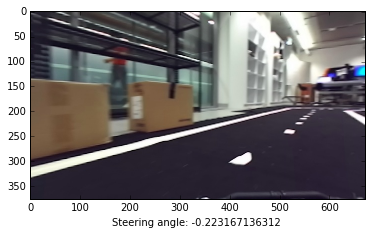

In [65]:
def show_image(index):
    print(df['file'][index])
    image = mpimg.imread(df['file'][index])
    print(image.shape)
    plt.imshow(image)
    plt.xlabel("Steering angle: {} ".format(df['steer'][index]))

show_image(130)

(528, 64, 64, 3)
(528, 1)
[[-0.19304444]
 [-0.23917177]
 [ 0.11819887]
 [-0.19369428]
 [-0.10167017]]


(array([ 11.,  16.,  27.,  28.,  57.,  57.,  56.,  31.,  30.,  44.,  42.,
         17.,  28.,  19.,  28.,   8.,   9.,   9.,   8.,   3.]),
 array([-0.34 , -0.306, -0.272, -0.238, -0.204, -0.17 , -0.136, -0.102,
        -0.068, -0.034,  0.   ,  0.034,  0.068,  0.102,  0.136,  0.17 ,
         0.204,  0.238,  0.272,  0.306,  0.34 ]),
 <a list of 20 Patch objects>)

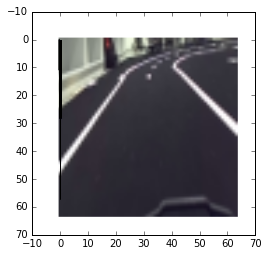

In [7]:
def get_images(df): 
    result = [] 
    for path in df["file"]: 
        img = mpimg.imread(path)
        img = img[150:, :]
#         img = misc.imresize(img, (113,168))
        img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
        result.append(img)
    return np.stack(result)

x = get_images(df)
print(x.shape)
y = df.as_matrix(columns=['steer'])
plt.imshow(x[0])
print(y.shape)
print(y[10:15])
plt.hist(y, bins=20)

In [8]:
# TODO: Build a model
import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D, Lambda, Input
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization
from keras.regularizers import l2

def Nvidia():
    model = Sequential()
#     model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    model.add(Conv2D(24, (3, 3), strides=(2, 2), padding="same", activation="relu", input_shape=(113,168,3)))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(36, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(48, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same", activation="relu"))
    model.add(BatchNormalization(axis=1, gamma_regularizer=l2(0.0001), beta_regularizer=l2(0.0001)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1000, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1))
    adam = Adam(lr=0.001)
    model.compile(adam, 'mae')
    return model

model = Nvidia()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 57, 84, 24)        672       
_________________________________________________________________
batch_normalization_6 (Batch (None, 57, 84, 24)        228       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 42, 36)        7812      
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 42, 36)        116       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 21, 48)        15600     
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 21, 48)        60        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 11, 64)         27712     
__________

In [66]:
import random

def trans_image(image,steer):
    # Translation
#     x_translation = translation_range*np.random.uniform()-translation_range/2
#     steer_ang = steer + x_translation/translation_range*2*.2
    steer_ang = steer + 0.2
    tx = 20
    ty = 0

    translation_matrix = np.float32([[1, 0, tx],
                                     [0, 1, ty]
                                     [0, 1, 1 ]])
    image_tr = cv.warpAffine(image,translation_matrix,(image.shape[1],image.shape[0]))
    
    return image_tr,steer_ang

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    toobright = image1[:,:,2] > 255/random_bright
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][toobright] = 255
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def crop_resize(img):
    img = img[150:, :]
#     img = cv.cvtColor(img, cv.COLOR_RGB2YUV)
    img = cv2.resize(img, (168, 113), interpolation=cv2.INTER_AREA)
    return img

def preprocess_img(row):
    img = None
    steering = None
    steering = row['steer']
        
    img = cv2.imread(row["file"])
#     img, steering = trans_image(img, steering)
    img = crop_resize(img)
    
    # randomly adjust brightness 
    img = augment_brightness_camera_images(img)
    
    #random flip
    flip = random.randint(0, 1)
    if flip == 1: 
        img = np.fliplr(img)
        steering = -steering
    
    return img, steering

-0.216081902385


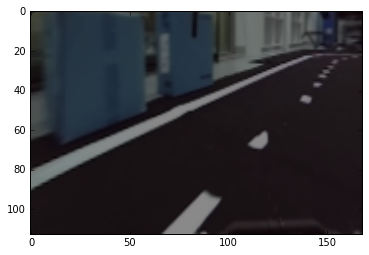

In [69]:
img, steering = preprocess_img(df.iloc[6])
print(steering)
plt.imshow(img)

In [85]:
## instead of above, and just plain training, let's use a generator to help randomly augment data

# df = df[(df['steering'] <= -0.01) | (df['steering'] >= 0.01)].reset_index(drop=True)

import sklearn
import cv2 as cv2
def generator(df, batch_size=256):
    
    while 1: # Loop forever so the generator never terminates
        x_sample = []
        y_sample = []
        pr_threshold = 1
        for i in range(batch_size):
            index = np.random.randint(len(df))
            row = df.iloc[index]
            image, steering = preprocess_img(row)
            keep_pr = 0
            while keep_pr == 0:
                image, steering = preprocess_img(row)
                pr_unif = np.random
                if abs(steering)<.001:
                    pr_val = np.random.uniform()
                    if pr_val>pr_threshold:
                        keep_pr = 1
                else:
                    keep_pr = 1
            pr_threshold = 0.99 * pr_threshold
            x_sample.append(image)
            y_sample.append(steering)
        yield np.stack(x_sample), np.asarray(y_sample).reshape(batch_size, 1)
#         pr_threshold = 0.90 * pr_threshold
        
train_generator = generator(df)
validation_generator = generator(df)

(array([   2.,    3.,    3.,   16.,   19.,   51.,   29.,   25.,   17.,
         163.,   19.,   14.,   23.,   43.,   44.,   20.,   14.,    3.,
           2.,    2.]),
 array([-0.32938263, -0.2959135 , -0.26244437, -0.22897523, -0.1955061 ,
        -0.16203697, -0.12856784, -0.09509871, -0.06162958, -0.02816044,
         0.00530869,  0.03877782,  0.07224695,  0.10571608,  0.13918521,
         0.17265435,  0.20612348,  0.23959261,  0.27306174,  0.30653087,
         0.34      ]),
 <a list of 20 Patch objects>)

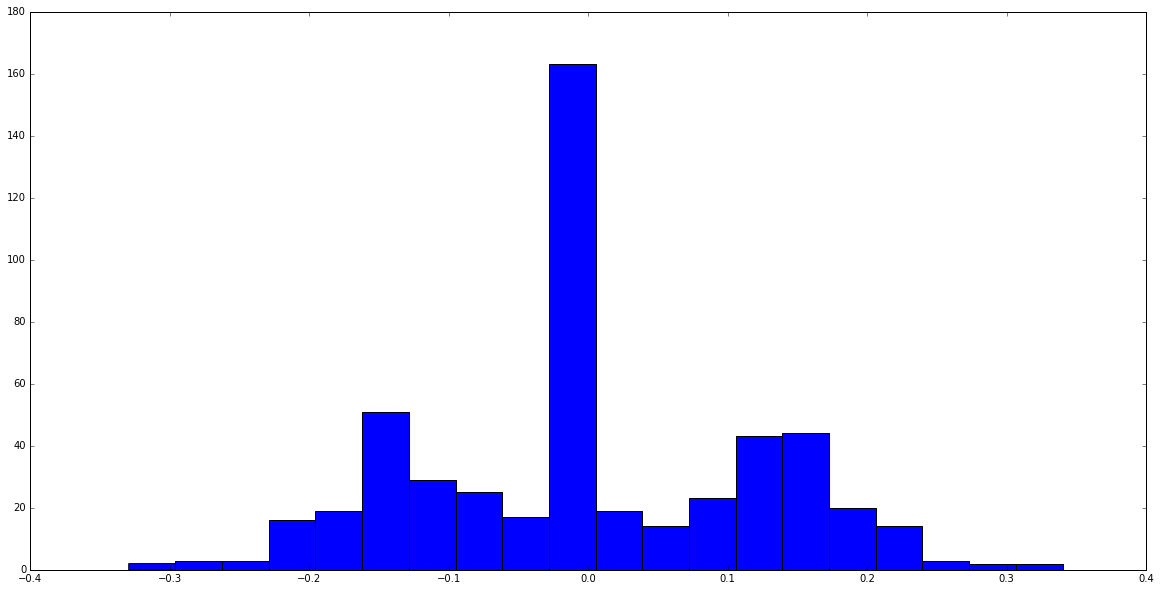

In [86]:
# testing distribution
test_y = [next(train_generator)[1] for i in range(2)]
test_y = np.vstack(test_y)

plt.figure(figsize=(20,10))
plt.hist(test_y, bins=20)
# this will shuffle a dataframe df.sample(frac=1).reset_index(drop=True)

In [72]:
model.optimizer.lr.assign(0.01)
history = model.fit_generator(train_generator, steps_per_epoch=10, epochs=10, verbose=1)


Epoch 1/10
10/10 [==============================] - 83s 8s/step - loss: 0.0772
Epoch 2/10
10/10 [==============================] - 75s 8s/step - loss: 0.0572
Epoch 3/10
10/10 [==============================] - 75s 7s/step - loss: 0.0500
Epoch 4/10
10/10 [==============================] - 72s 7s/step - loss: 0.0467
Epoch 5/10
10/10 [==============================] - 68s 7s/step - loss: 0.0434
Epoch 6/10
10/10 [==============================] - 66s 7s/step - loss: 0.0413
Epoch 7/10
10/10 [==============================] - 65s 7s/step - loss: 0.0393
Epoch 8/10
10/10 [==============================] - 65s 6s/step - loss: 0.0369
Epoch 9/10
10/10 [==============================] - 65s 6s/step - loss: 0.0354
Epoch 10/10
10/10 [==============================] - 65s 7s/step - loss: 0.0347


['loss']


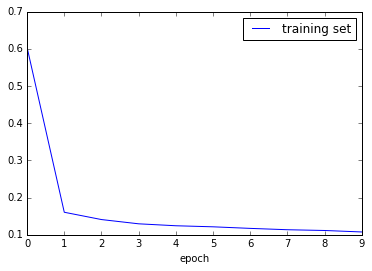

In [14]:
### print the keys contained in the history object
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [73]:
model.save('./driving_net_model.h5')
model.save_weights("./driving_net_weights.h5")

In [ ]:
# from keras.models import load_model
# model = load_model('./model.h5')

CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 14.1 ms
('index:', 1635, ' actual: ', -0.099238552153099999, ' prediction:', -0.11953797, ' diff:', -0.020299419760714546)
CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 13.3 ms
('index:', 2540, ' actual: ', 0.0, ' prediction:', -0.0093260854, ' diff:', -0.0093260854482650757)
CPU times: user 24 ms, sys: 8 ms, total: 32 ms
Wall time: 14.3 ms
('index:', 461, ' actual: ', 0.0, ' prediction:', -0.016285822, ' diff:', -0.016285821795463562)
CPU times: user 40 ms, sys: 4 ms, total: 44 ms
Wall time: 14.4 ms
('index:', 735, ' actual: ', 0.0, ' prediction:', -0.015130773, ' diff:', -0.015130773186683655)
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 9.55 ms
('index:', 1263, ' actual: ', 0.0, ' prediction:', -0.013953194, ' diff:', -0.01395319402217865)
CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 10.3 ms
('index:', 1684, ' actual: ', -0.042588185519000003, ' prediction:', -0.049515933, ' diff:', -0.00

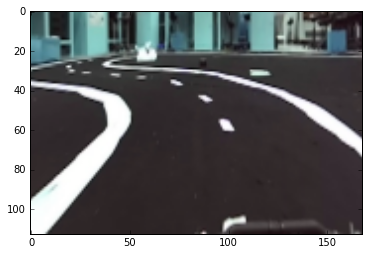

In [76]:
import random

# x, y = next(generator(df))


for i in range(1, 10):
    test_index=random.randint(0, len(df))
#     print(test_index)
    test_image = cv2.imread(df['file'][test_index])
    test_image = crop_resize(test_image)
    y  = df['steer'][test_index]
#     print(y[test_index])
    %time prediction = model.predict(test_image[None, :, :, :], batch_size=1)[0][0]
    print("index:", test_index, " actual: ", y, " prediction:", prediction, " diff:", prediction - y)


plt.imshow(test_image)